In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from utils.binary_ind import make_to_binary, modify_weights, apply_mask_binary

In [9]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [11]:
net = Net().to(device)
individuo = Net().to(device)

Cargamos los datos

In [12]:
# Definimos el transform para los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargamos el dataset de MNIST
train_dataset = datasets.MNIST('./../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./../data', train=False, download=True, transform=transform)

# Definimos los DataLoaders para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

In [13]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [14]:
# train loop
train_loss = []
train_loss_mean = []
test_accuracies = []
n_individuo = 1
accuracy_threshold = 0.4

#Guardo el mejor individuo y la red original que tendrá que ser reestablecida cad epoca
individuo = make_to_binary(individuo)
best_individo_state_dict = individuo.state_dict()
net_state_dict = net.state_dict()

#train loop
while True:
    net.load_state_dict(net_state_dict)
    if n_individuo == 1:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask_binary(net, individuo)

        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            #loss.backward()
            #optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        #train_loss_mean.append(np.mean(train_loss))
        test_accuracies.append(accuracy)
        #print(f"Accuracy: {accuracy}, loss mean: {train_loss_mean[-1]}")
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        best_loss = train_loss[-1]
        if accuracy > accuracy_threshold:
            break
        n_individuo += 1

        #Variamos el individuo desde el anterior para obtener uno nuevo
        nuevo_individuo = modify_weights(individuo)
        
    else:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask_binary(net, nuevo_individuo)
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        if accuracy > accuracy_threshold:
            break

        # Verificamos que individuo tiene mejor desempeño
        if train_loss[-1] < best_loss:
            print("Nuevo mejor individuo")
            best_loss = train_loss[-1]
            best_individo_state_dict = nuevo_individuo.state_dict()
        
        # actualizamos el individuo
        individuo.load_state_dict(best_individo_state_dict)

        # Variamos el individuo desde el anterior para obtener uno nuevo
        nuevo_individuo = modify_weights(individuo)

        n_individuo += 1         

 --------------------- Individuo 1 --------------------- 
Accuracy: 0.0957 Loss: 2.3025047212267227
 --------------------- Individuo 2 --------------------- 
Accuracy: 0.0958 Loss: 2.302485125913803
Nuevo mejor individuo
 --------------------- Individuo 3 --------------------- 
Accuracy: 0.0962 Loss: 2.302437492779323
Nuevo mejor individuo
 --------------------- Individuo 4 --------------------- 
Accuracy: 0.076 Loss: 2.302672030829163
 --------------------- Individuo 5 --------------------- 
Accuracy: 0.0958 Loss: 2.3027133232494914
 --------------------- Individuo 6 --------------------- 
Accuracy: 0.0869 Loss: 2.3028554944341373
 --------------------- Individuo 7 --------------------- 
Accuracy: 0.0938 Loss: 2.3028765993077616
 --------------------- Individuo 8 --------------------- 
Accuracy: 0.0957 Loss: 2.3025567696801126
 --------------------- Individuo 9 --------------------- 
Accuracy: 0.0983 Loss: 2.3025710148089478
 --------------------- Individuo 10 --------------------- 
A

KeyboardInterrupt: 

In [15]:
print(train_loss)
print(test_accuracies)
print(max(test_accuracies))
index_max_accuracy = test_accuracies.index(max(test_accuracies))
print(index_max_accuracy)
print("-----------------")
print(min(train_loss))
index = train_loss.index(min(train_loss))
print(index)

[2.3025047212267227, 2.302485125913803, 2.302437492779323, 2.302672030829163, 2.3027133232494914, 2.3028554944341373, 2.3028765993077616, 2.3025567696801126, 2.3025710148089478, 2.302532139109142, 2.3025703333588297, 2.3026243974405056, 2.3026323516739966, 2.3024911173879463, 2.301961524145944, 2.3019749320137985, 2.302129301435149, 2.3020615404856994, 2.301992319540174, 2.3019773683059954, 2.3019352454874817, 2.3024868217866814, 2.3024175858446783, 2.30210872220078, 2.3025559186935425, 2.302578025789403, 2.3026135000847043, 2.3025167456059568, 2.3023841983473887, 2.3025931168212566, 2.302556969717876, 2.302541957481075, 2.3025734124661508, 2.302458296960859, 2.3024423419793787, 2.3025795028153766, 2.3026464046445736, 2.302566257875357, 2.302607463112772, 2.3025519453894607, 2.3026048928689855, 2.3026507841244435, 2.302533781096371, 2.3024963991982594, 2.3025164652480754, 2.302557522045778, 2.3025541791021187, 2.3024575682337094, 2.302504457644562, 2.302418565445109, 2.3024207287505747

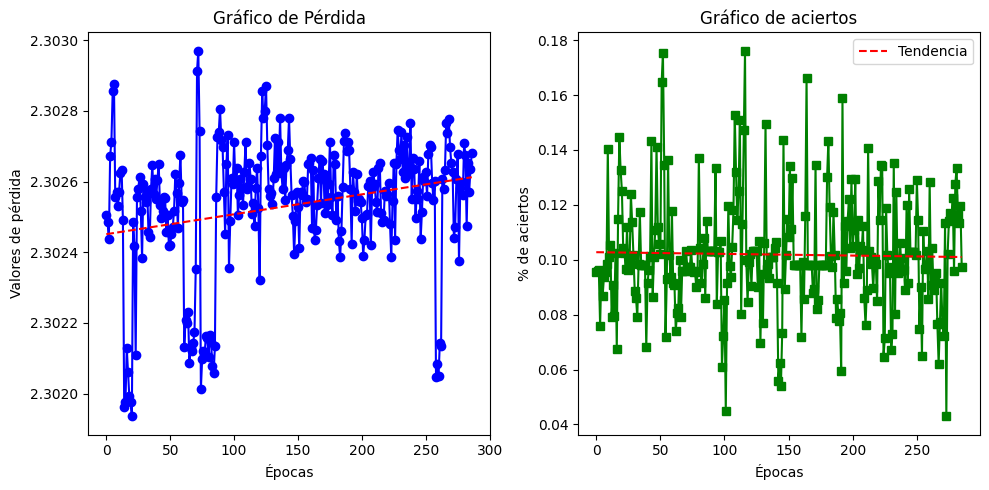

In [16]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Valores de pérdida")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("Épocas")
plt.ylabel("% de aciertos")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()